# Cognitive Algorithms - Assignment 5 (30 points)
Cognitive Algorithms        
Winter term 2017/2018      
Technische Universität Berlin     
Fachgebiet Maschinelles Lernen 

**Due on Januar 18, 2018 10am via ISIS **
                    
After completing all tasks, run the whole notebook so that the content of each cell is properly displayed. Make sure that the code was ran and the entire output (e.g. figures) is printed. Print the notebook as a PDF file and again make sure that all lines are readable - use line breaks in the Python Code '\' if necessary. Points will be deducted, if code or content is not readable!                  
           
**Upload the PDF file that contains a copy of your notebook on ISIS.** 

# Part 2: Programming (22 points)
---

The application in this assignment is the same as in assignment 4. You will predict two dimensional hand positions $y \in \mathbb{R}^2$ from electromyographic (EMG) recordings $x \in \mathbb{R}^{192}$ obtained with high-density electrode arrays on the lower arm.     
Labels are 2D positions of the hand during different hand movements.

Remember that even after 'linearizing' the EMG-hand position relationship by computing the log of the EMG features, the relationship is not exactly linear. Also we do not know the exact non-linearity; it might not be the same for all regions in EMG space and for all electrodes. So we can hope to gain something from using a non-parametric and non-linear method like kernel ridge regression.

The criterion to evaluate the model and select optimal parameters is the so called coefficient of determination, or $r^2$ index
$$r^2 = 1-\frac{\sum_{d=1}^D \mathbb{V}(\hat{y}_d-y_d)}{\sum_{d=1}^D \mathbb{V}(y_d)}$$
where $D$ is the dimensionality of the data labels, $y$ are the true labels and $\hat{y}$ the estimated labels. This score is 1 for perfect predictions and smaller otherwise.

Use the data set ```myo_data.mat``` from the last assignment. 

In [2]:
import pylab as pl
import scipy as sp
from numpy.linalg import inv
from numpy.linalg import solve
from scipy.io import loadmat
import numpy as np
from scipy.spatial.distance import cdist
%matplotlib inline

In [81]:
def load_data(fname):
    ''' Loads EMG data from <fname> '''
    # load the data
    data = loadmat(fname)
    # extract data for training
    X_train = data['training_data']
    X_train = sp.log(X_train)
    X_train = X_train[:, :1000]
    # extract hand positions
    Y_train = data['training_labels']
    Y_train = Y_train[:, :1000]
    return X_train,Y_train

def GaussianKernel(X1, X2, kwidth):
    ''' Compute Gaussian Kernel 
    Input: X1    - DxN1 array of N1 data points with D features 
           X2    - DxN2 array of N2 data points with D features 
           kwidth - Kernel width
    Output K     - N1 x N2 Kernel matrix
    '''
    assert(X1.shape[0] == X2.shape[0])
    K = cdist(X1.T, X2.T, 'euclidean')
    K = np.exp(-(K ** 2) / (2. * kwidth ** 2))
    return K

def train_krr(X_train, Y_train,kwidth,llambda):
    ''' Trains kernel ridge regression (krr)
    Input:       X_train  -  DxN array of N data points with D features
                 Y_train  -  D2xN array of length N with D2 multiple labels
                 kwdith   -  kernel width
                 llambda    -  regularization parameter
    Output:      alphas   -  NxD2 array, weighting of training data used for apply_krr                     
    '''
    # your code here
    K = GaussianKernel(X_train, X_train, kwidth)
    alphas = sp.dot(sp.linalg.inv(K+llambda*sp.identity(X_train.shape[1])),Y_train.T)
    return alphas
    
    
def apply_krr(alphas, X_train, X_test, kwidth):
    ''' Applys kernel ridge regression (krr)
    Input:      alphas      -  NtrxD2 array trained in train_krr      
                X_train     -  DxNtr array of Ntr train data points with D features
                X_test      -  DxNte array of Nte test data points with D features
                kwidht      -  Kernel width             
    Output:     Y_test      -  D2xNte array
    '''
    # your code here
    K = GaussianKernel(X_test,X_train,kwidth)
    return sp.dot(K, alphas).T

def train_ols(X_train, Y_train):
    ''' Trains ordinary least squares (ols) regression 
    Input:       X_train  -  DxN array of N data points with D features
                 Y        -  D2xN array of length N with D2 multiple labels
    Output:      W        -  DxD2 array, linear mapping used to estimate labels 
                             with sp.dot(W.T, X)                      
    '''
    #W = sp.dot(inv(sp.dot(X_train,X_train.T)),sp.dot(X_train,Y_train.T))
    W = solve(sp.dot(X_train,X_train.T),sp.dot(X_train,Y_train.T))
    return W
    
def apply_ols(W, X_test):
    ''' Applys ordinary least squares (ols) regression 
    Input:       X_test    -  DxN array of N data points with D features
                 W        -  DxD2 array, linear mapping used to estimate labels 
                             trained with train_ols                   
    Output:     Y_test    -  D2xN array
    '''
    Y_test = sp.dot(W.T, X_test)
    return Y_test

def test_handpositions():
    X,Y = load_data('myo_data.mat')
    crossvalidate_krr(X,Y)

def test_sine_toydata(kwidth = 1, llambda = 1):
    #Data generation
    X_train = sp.arange(0,10,.01)
    X_train = X_train[None,:]
    Y_train = sp.sin(X_train) + sp.random.normal(0,.5,X_train.shape)
    #Linear Regression 
    w_est = train_ols(X_train, Y_train) 
    Y_est_lin = apply_ols(w_est,X_train)
    #Kernel Ridge Regression
    alphas = train_krr(X_train,Y_train,kwidth,llambda)
    Y_est_krr = apply_krr(alphas,X_train,X_train,kwidth)
    
    #Plot result
    pl.figure()
    pl.plot(X_train.T, Y_train.T, '+k', label = 'Train Data')
    pl.plot(X_train.T, Y_est_lin.T, '-.', linewidth = 2, label = 'OLS')
    pl.plot(X_train.T, Y_est_krr.T,  'r', linewidth = 2, label = 'KRR')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title(r'$\lambda$ = ' + str(llambda) + '   $\sigma$ = ' + str(kwidth))
    pl.legend(loc = 'lower right')
    
      
def crossvalidate_krr(X,Y,f=5, kwidths=10.0**np.array([0, 1, 2]), llambdas=10.0**np.array([-4, -2, 0])):
    ''' 
    Test generalization performance of kernel ridge regression with gaussian kernel
    Input:      X   data (dims-by-samples)
                Y   labels (dims2-by-samples)
                f   number of cross-validation folds
                kwidths width of gaussian kernel function 
                llambdas regularizer (height of ridge on kernel matrix)
    '''
    N = int(f*(X.shape[-1]/f))
    idx = sp.reshape(sp.random.permutation(sp.arange(N)),(f,int(N/f)))
    r2_outer = sp.zeros((f))
    r2_linear = sp.zeros((f))
    r2_inner = sp.zeros((f-1,kwidths.shape[-1],llambdas.shape[-1]))
    
    # to outer cross-validation (model evaluation)
    for ofold in range(f):
        # split in training and test (outer fold)
        otestidx = sp.zeros((f),dtype=bool)
        otestidx[ofold] = 1
        otest = idx[otestidx,:].flatten()
        otrain = idx[~otestidx,:]
        
        # inner cross-validation (model selection)
        for ifold in range(f-1):
            # split in training and test (inner fold)
            itestidx = sp.zeros((f-1),dtype=bool)
            itestidx[ifold] = 1
            itest = otrain[itestidx,:].flatten()
            itrain = otrain[~itestidx,:].flatten()
            
            # do inner cross-validation (model selection)
            for illambda in range(llambdas.shape[-1]):
                for ikwidth in range(kwidths.shape[-1]):
                    #compute kernel for all data points
                    alphas = train_krr(X[:,itrain],Y[:,itrain],kwidths[ikwidth],llambdas[illambda])
                    yhat = apply_krr(alphas, X[:,itrain], X[:,itest],kwidths[ikwidth])
                    r2_inner[ifold,ikwidth,illambda] = compute_rsquare(yhat,Y[:,itest])

        #train again using optimal parameters
        r2_across_folds = r2_inner.mean(axis=0)
        optkwidthidx, optllambdaidx = np.unravel_index(r2_across_folds.flatten().argmax(),r2_across_folds.shape)
        #evaluate model on outer test fold
        alphas = train_krr(X[:,otrain.flatten()],Y[:,otrain.flatten()], kwidths[optkwidthidx],llambdas[optllambdaidx])
        yhat = apply_krr(alphas, X[:,otrain.flatten()],X[:,otest], kwidths[optkwidthidx])
        r2_outer[ofold] = compute_rsquare(yhat,Y[:,otest])

        # for comparison: predict with linear model
        w_est = train_ols(X[:,otrain.flatten()], Y[:,otrain.flatten()]) 
        y_est_lin = apply_ols(w_est,X[:,otest])
        r2_linear[ofold] = compute_rsquare(y_est_lin,Y[:,otest])
        
        print ('Fold %d'%ofold + ' best kernel width %f'%kwidths[optkwidthidx] +\
        ' best regularizer %f'%llambdas[optllambdaidx] + \
        ' rsquare %f'%r2_outer[ofold] + \
        ' rsquare linear %f'%r2_linear[ofold])
    pl.figure()
    pl.boxplot(sp.vstack((r2_outer,r2_linear)).T)
    pl.ylabel('$r^2$')
    pl.xticks((1,2),('KRR','Lin'))
    #pl.savefig('krr_vs_lin_comparison.pdf')
    return r2_outer,r2_linear
    
def compute_rsquare(yhat,Y):
    '''compute coefficient of determination'''
    return 1 - (sp.var((yhat - Y),axis=1).sum()/sp.var(Y,axis=1).sum())

**A) (6 points)** Implement Kernel Ridge Regression (KRR) by completing the function stubs  ```krr_train``` and  ```krr_apply```. 
We use the notation from assignment 4, 
$$X_{\text{train}} \in \mathbb{R}^{D_X \times N_{tr}}, \;  Y_{\text{train}} \in \mathbb{R}^{D_Y \times N_{tr}}, \; X_{\text{test}} \in \mathbb{R}^{D_X \times N_{te}}$$
In ```krr_train```, you estimate a linear combination of the input vectors $\alpha$, 
$$\alpha = (K + \lambda I)^{-1}Y_{\text{train}}^T$$
where $\lambda$ is the regularization parameter and $K$ is the $N_{tr} \times N_{tr}$ Gaussian Kernel matrix with Kernel width $\sigma$, $K_{ij} =  \exp\left( - \frac{\| X_{\text{train}}^i - X_{\text{train}}^j\|^2}{\sigma^2} \right)$. You can compute $K$ with the provided function ```GaussianKernel```.

The function ```krr_apply``` than uses the weights $\alpha$ to predict the (unknown) hand positions of new test data $X_{\text{test}}$
$$Y_{\text{test}} = (\mathbf{k} \alpha)^T.$$
where $\mathbf k$ is the $N_{\text{test}} \times N_{\text{train}}$ matrix $\mathbf{k}_{ij} =   \exp\left( - \frac{\| X_{\text{test}}^i - X_{\text{train}}^j\|^2}{\sigma^2}\right)$.    

The function  ```test_sine_toydata``` helps you to debug your code. It generates toy data that follows a sine function, $x_i \in \{0, 0.01, 0.02, \ldots, 10\}, y_i = \sin(x_i) + \epsilon, \epsilon \sim \mathcal{N}(0, 0.5)$. The result of KRR should resemble the sine function.

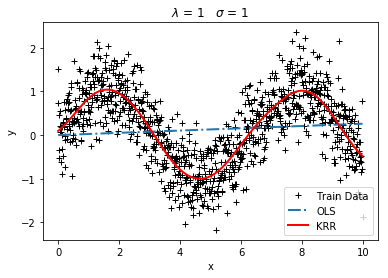

In [75]:
test_sine_toydata()

**B) (5 points)** We want to analyse how the Kernel Ridge solution depends on its hyperparameters, the kernel width $\sigma$ and  the regularization parameter $\lambda$. 
- Call the function  ```test_sine_toydata```  with $\lambda$ = 1 for three different Kernel widths, $\sigma = \{ 0.1, 1, 10\}$. How does the Kernel width affect the solution? Explain the observed behaviour.  
- Call the function  ```test_sine_toydata```  with $\sigma$ = 1 for three different regularization parameters, $\lambda = \{ 10^{-10}, 1, 500\}$. How does the regularization parameter affect the solution? Explain the observed behaviour.  

**[Your answers for B) here]**
- with the kernel width we can adjust our model to the data and find a good generalization. for a kernel width of 0.1 we see overfitting whereas a kernel width of 10 results in strong underfitting. the kernel width of 1 fits the best in this case. 
- by increasing the regularization parameter $\lambda$ we can lower the variance and generalize the model, so that we get similar plots with different runs. by multiple running the test_sine_toydata we observe very different plots for $\lambda = 10^{-10}$ whereas we see always a very similar plot for $\lambda = 500$. but for that value of $\lambda$ we see underfitting again, as the variance is lowered too much. the best fit is for $\lambda = 1$   

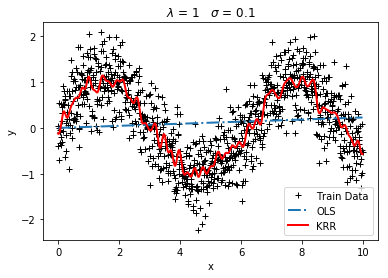

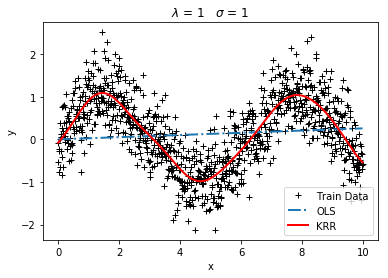

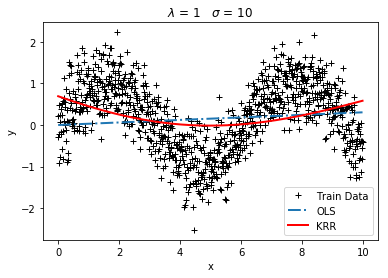

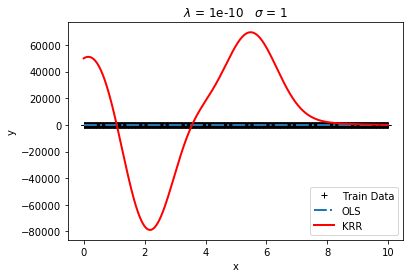

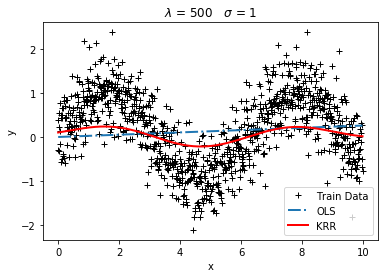

In [63]:
test_sine_toydata(kwidth = 0.1, llambda = 1)
test_sine_toydata(kwidth = 1, llambda = 1)
test_sine_toydata(kwidth = 10, llambda = 1)
test_sine_toydata(kwidth = 1, llambda = 1e-10)
test_sine_toydata(kwidth = 1, llambda = 500)

**C) (4 points)**  Briefly explain in your own words how nested-crossvalidation is done. To do so, you can examine the function ```crossvalidate_krr```.Explain briefly how $\lambda$ and $\sigma$ are chosen within the function. 

**[Your answers for C) here]**
we split training data in different folds and iterate through every fold. this is the fold for testing in every iteration. in every iteration of that outer fold we iterate again thourgh our folds, exept that fold of the current outer iteration and we compute for each inner iteration step $\lambda$ and $\sigma$ that build up a model and compute the prediction. when we finished inner iteration circle, we compare the different models and chose the best model = that has the best accuracy and train it with all inner folds. after that we test this model with our current outer fold. then we repeat this for every outer fold. in the end we get for each fold the best values for $\lambda$ and $\sigma$.

Fold 0 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.958787 rsquare linear 0.910375
Fold 1 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.958614 rsquare linear 0.922030
Fold 2 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.959148 rsquare linear 0.909005
Fold 3 best kernel width 10.000000 best regularizer 0.000100 rsquare 0.949180 rsquare linear 0.909978
Fold 4 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.965411 rsquare linear 0.928580


(array([ 0.95878745,  0.95861394,  0.95914806,  0.94918042,  0.96541115]),
 array([ 0.91037464,  0.92203005,  0.90900535,  0.90997835,  0.92858048]))

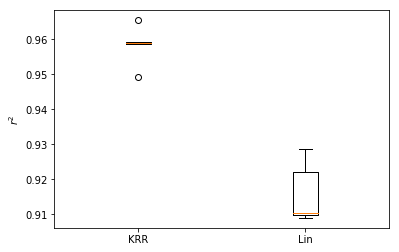

In [82]:
x,y = load_data('myo_data.mat')
crossvalidate_krr(x,y)

**D) (6 points)** Predict two dimensional hand positions with Kernel Ridge Regression by calling the function ``` test_handpositions```. It shows a boxplot for the linear regression and the Kernel Ridge Regression.  What does a boxplot show? (check the help function in python or the wikipedia article). Do we gain something from Kernel Ridge Regression as compared to simple linear regression? 

**[Your answers for D) here]** 
the boxplot shows that our results for kernel ridge regression the median $r^2$ value is much closer to 1 than for simple linear regression. even the worst $r^2$ value is better for kkr than the best $r^2$ value for simple linear regression. that means that we find a better model with kkr. as the median for simple linear regression is very close to the maximum value it seems like there is a border around 0.925 that simple linear regression cannot overcome.

Fold 0 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.947692 rsquare linear 0.902656
Fold 1 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.963686 rsquare linear 0.924347
Fold 2 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.961510 rsquare linear 0.924101
Fold 3 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.967527 rsquare linear 0.924763
Fold 4 best kernel width 10.000000 best regularizer 0.010000 rsquare 0.955261 rsquare linear 0.912060


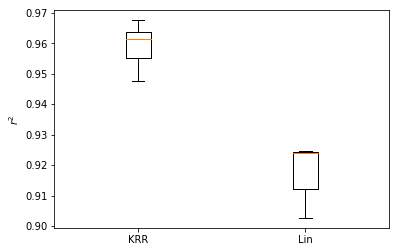

In [83]:
test_handpositions()

**E) (1 point)** In the last task, we have applied the function ```test_handpositions``` only to the first $1000$ data points out of the $10255$ available data points. Why did we do so in this exercice?

**[Your answers for E) here]**
Kernel ridge regression is difficult for large data sets. it would be very intensive in computing as we have 4x for-loops in the code. applying the function to all data points would need too much time.